In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kontrol import *
from kontrol.model import make_weight
from control import *
import dtt2hdf

In [2]:
items = dtt2hdf.read_diaggui('./data/BS_IP_noise_20200721.xml')
f = items.results.PSD['K1:VIS-BS_IP_BLEND_ACCL_IN1'].FHz
noise_lvdtt_data = items.results.PSD['K1:VIS-BS_IP_BLEND_LVDTT_IN1'].PSD[0]
noise_geot_data = items.results.PSD['K1:VIS-BS_IP_BLEND_ACCT_IN1'].PSD[0]

mask = (f > 1e-2) & (f < 1e1)
f = f[mask]
noise_lvdtt_data = noise_lvdtt_data[mask]
noise_geot_data = noise_geot_data[mask]

In [135]:
from scipy.optimize import minimize
def noise2zpk(f, noise_data, x0 = None, bounds=None, max_order=20, weight=None):
    """ Noise spectrum regression using zpk defined transfer function.
    
    Parameter
    ---------
        f: numpy.ndarray
            Frequency axis of the noise spectrum. In Hz.
        noise_data: numpy.ndarray
            The amplitude/amplitude spectral density of the noise.
        x0: numpy.ndarray, optional
            Initial guess for of the noise model parameters. If not specified,
            zeros and poles will be default to logrithmic center of f, gain
            will be defaulted to noise_data[0]
        bounds: tuple of (float, float), optional
            The bounds for the zeros and poles in unit of Hz.
            This will default to (min(f) - 1 decade, max(f +1 decade),
            if not specified. The bounds for the gain goes
            to the last entry and is defaulted to be
            (noise_data[0]*1e-6, noise_data[0]*1e6)
        max_order: int, optional
            The maximum number of zeros and poles. Note that the number
            of zeros and poles are the same in this regression.
            Defaults to be 20, maximum allowable order in foton.
        weight: numpy.ndarray, optional
            Weightings in frequency domain that will be multiplied to the
            residues before summing. This can be used to filter unwanted data
            or to emphasize particular frequency regions.
    
    Returns
    -------
        noise_zpk: control.xferfcn.TransferFunction
            The regressed transfer function with magnitude profile
            matching the noise spectrum specified.
    
    Notes
    -----
        The reason why the numbers of zeros and poles are the same here
        is because the magnitude have to be bounded, i.e. flat at
        very low and very high frequencies, for H2 and H-infinity synthesis
        to work. This doesn't really matter if the flattness only happens at
        irrelevant frequencies. We can always modify the final filter by
        removing the corresponding zeros/poles that make the filter flat.
    """
    
    if x0 is None:
        log_center = (np.log10(max(f)) + np.log10(min(f))) / 2
        log_center = 10**log_center
        x0 = np.ones(max_order*2) * log_center
        x0 = np.append(x0, noise_data[0])
#     print(len(x0))
    if bounds is None:
        bounds = [(min(f)*0.1, max(f)*10)]*max_order*2
        bounds.append([noise_data[0]*1e-6, noise_data[0]*1e6])
#     print(len(bounds))
    if weight is None:
        weight = np.ones_like(noise_data)
        
    def args2zpk(args):
        """ Convert a list of arguments to zpk transfer function.
        
        Parameters
        ----------
            args: list of floats
                Length must be odd. The last number is gain. The first half of
                the rest are zeros, and the second half are poles.
        return
        ------
            control.xferfcn.TransferFunction
                The transfer function defined with the arguments.
        """
        
        zeros = args[0:int(len(args)/2)]
        poles = args[int(len(args)/2):len(args)-1]
        gain = args[-1]
        return(zpk(zeros, poles, gain))
    
    def cost(args):
        zpk_fit = args2zpk(args)
        mag_fit = abs(zpk_fit.horner(2*np.pi*1j*f)[0][0])
        residue = sum(np.sqrt(((mag_fit - noise_data) / noise_data * weight)**2))
        return(residue)
            
    res = minimize(cost, x0=x0, bounds=bounds, method='Powell', options={'disp':True})
#     print(bounds)
#     print(res.x)
    noise_zpk = args2zpk(res.x)
    return(noise_zpk)
    

In [136]:
weight = np.exp(-f)
noise_lvdtt_fit=noise2zpk(f, noise_lvdtt_data, max_order=10, weight=weight)
noise_geot_fit=noise2zpk(f, noise_geot_data, max_order=10, weight=weight)

Optimization terminated successfully.
         Current function value: 28.268235
         Iterations: 25
         Function evaluations: 15476
Optimization terminated successfully.
         Current function value: 29.009633
         Iterations: 13
         Function evaluations: 7771


In [208]:
noise_geot_fit_aug = (noise_geot_fit
                      *tf([1, -noise_geot_fit.pole()[-1]],[1])
                      *tf([1, -noise_geot_fit.pole()[-2]],[1])
                      *tf([1, -noise_geot_fit.pole()[-3]],[1])
                      *tf([1],[1,2*np.pi*min(f)])**3)

Text(0.5, 0, 'Frequency (Hz)')

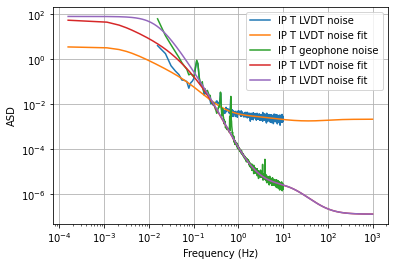

In [209]:
_f=np.linspace(min(f)*1e-2, max(f)*1e2, 1000000)
plt.loglog(f, noise_lvdtt_data, label='IP T LVDT noise')
plt.loglog(_f, abs(noise_lvdtt_fit.horner(2*np.pi*1j*_f)[0][0]), label='IP T LVDT noise fit')
plt.loglog(f, noise_geot_data, label='IP T geophone noise')
plt.loglog(_f, abs(noise_geot_fit.horner(2*np.pi*1j*_f)[0][0]), label='IP T LVDT noise fit')
plt.loglog(_f, abs(noise_geot_fit_aug.horner(2*np.pi*1j*_f)[0][0]), label='IP T LVDT noise fit')


plt.legend(loc=0)
plt.grid()
plt.ylabel('ASD')
plt.xlabel('Frequency (Hz)')

In [51]:
noise_geot_tf = tf([1,2,3,4,5],[1,2,3,4,5,6])
x0 = list(noise_geot_tf.num[0][0])+list(noise_geot_tf.den[0][0])
weight = make_weight(f, ((0.07, 0.9), 0))
res = minimize(cost, args=(noise_geot_tf, f, noise_geot_data, weight), x0=x0)
res.x

array([ 1.02350981e-07, -4.04097319e-02,  8.61603423e-01, -9.94982268e+00,
        1.22283911e+01,  1.06055449e+00,  3.11836096e+02,  3.18296152e+02,
       -6.33870797e+01,  1.77895813e+00, -7.84834231e-01])

In [215]:
from kontrol.filter import h2complementary
h1, h2 = h2complementary(noise_lvdtt_fit/noise_geot_fit_aug, noise_geot_fit_aug/noise_lvdtt_fit)

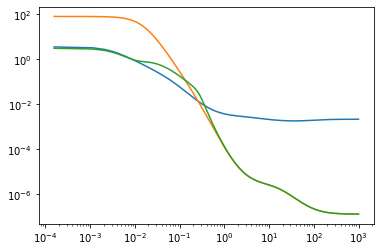

In [221]:
# f=np.logspace(-3,3,1000)
# plt.loglog(_f, abs(h1.horner(2*np.pi*1j*_f)[0][0]))
# plt.loglog(_f, abs(h2.horner(2*np.pi*1j*_f)[0][0]))
# plt.loglog(_f, abs(h2_aug.horner(2*np.pi*1j*_f)[0][0]))
# plt.loglog(_f, abs((h1+h2_aug).horner(2*np.pi*1j*_f)[0][0]))

# plt.ylim(0.1,10)
plt.loglog(_f, abs(noise_lvdtt_fit.horner(2*np.pi*1j*_f)[0][0]))
plt.loglog(_f, abs(noise_geot_fit_aug.horner(2*np.pi*1j*_f)[0][0]))
plt.loglog(_f, quad_sum(abs(noise_lvdtt_fit.horner(2*np.pi*1j*_f)[0][0])*abs(h1.horner(2*np.pi*1j*_f)[0][0]),
                        abs(noise_geot_fit_aug.horner(2*np.pi*1j*_f)[0][0])*abs(h2_aug.horner(2*np.pi*1j*_f)[0][0])))

In [217]:
h2.zero()

array([-6.68240104e+02+1.79821281e+01j, -6.68240104e+02-1.79821281e+01j,
       -6.45620210e+02+4.56038445e+01j, -6.45620210e+02-4.56038445e+01j,
       -6.46097271e+02+0.00000000e+00j, -6.07679922e+02+5.31177341e+01j,
       -6.07679922e+02-5.31177341e+01j, -5.67572658e+02+3.63758170e+01j,
       -5.67572658e+02-3.63758170e+01j, -5.48000303e+02+0.00000000e+00j,
       -4.90176532e+02+2.18602431e+00j, -4.90176532e+02-2.18602431e+00j,
       -2.38841087e+02+8.30967010e-02j, -2.38841087e+02-8.30967010e-02j,
       -1.13204414e+02+1.23348839e+00j, -1.13204414e+02-1.23348839e+00j,
       -9.82370432e+01+4.97576627e+00j, -9.82370432e+01-4.97576627e+00j,
       -8.93348926e+01+6.62543160e+00j, -8.93348926e+01-6.62543160e+00j,
       -8.03248167e+01+3.76737529e+00j, -8.03248167e+01-3.76737529e+00j,
       -7.18553699e+01+9.30414902e-01j, -7.18553699e+01-9.30414902e-01j,
       -4.92092679e+01+1.02051880e-02j, -4.92092679e+01-1.02051880e-02j,
       -1.51622758e+00+2.34308128e+00j, -1.51622758

In [218]:
h2_aug = h2/tf([1, -h2.zero()[-1]],[1])/tf([1, -h2.zero()[-2]],[1])/tf([1, -h2.zero()[-3]],[1])/tf([1, -h2.zero()[-4]],[1])
# h2_aug = h2/tf([1/1.02740754e-2, 1],[1])/tf([1/1.60787326e-2, 1],[1])/tf([1/1.65289665e-1, 1],[1])
h2_aug = h2_aug*tf([1,0],[1])**4

In [187]:
h2.zero()[-2]

(-0.016080250937094934+0j)

In [39]:
noise_lvdtt_fit.pole()

array([-1.28800324e+01+0.j        ,  1.02358516e-07+0.75129115j,
        1.02358516e-07-0.75129115j, -1.41929067e-06+0.11407442j,
       -1.41929067e-06-0.11407442j])

In [7]:
# def make_weight(x, *segments, default_weight=1.):
#     """Make weighting functions for data fitting
    
#     Parameters
#     ----------
#         x: list or np.ndarray
#             The data points for evaluation
#         *segments: tuples of (tuple of (float, float), float)
#             Set weights values for segments of the data. 
#             The first entry specify the bound of the segment.
#             The second entry specify the weight of the segment.
#             Use np.inf for unbounded segments.
#         default_weight: float, optional
#             The default value of the weighting function.
#             Defaults to be 1.
    
#     Returns
#     -------
#         weight: np.ndarray
#             The weighting function as specfied.
#     """

#     weight = np.ones_like(x) * default_weight
    
#     for seg in segments:
#         lower = seg[0][0]
#         upper = seg[0][1]
#         weight_val = seg[1]
#         if lower > upper:
#             _ = lower
#             lower = upper
#             upper = _
#         mask_bool = (x >= lower) & (x <= upper) 
#         mask_value = mask_bool * weight_val
#         weight *= np.logical_not(mask_bool)
#         weight += mask_value
    
#     return(weight)

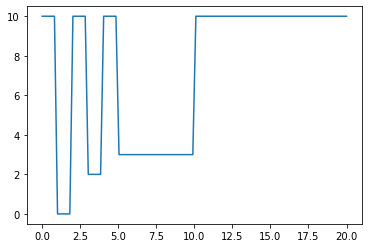

In [8]:
x = np.linspace(0,20, 100)
weight = make_weight(x, ((1, 2), 0), ((3, 4), 2), ((5, 10), 3), default_weight=10)
plt.plot(x, weight)
# plt.plot(weight)

In [37]:
a=[1,2,3,4]
a[1:3]=[4,5]
a

[1, 4, 5, 4]

In [45]:
mask=(f>0)&(f<10)
f*np.logical_not(mask)

array([  0.        ,   0.        ,   0.        , ...,  99.99218628,
        99.99999939, 100.0078125 ])